# Homework 5: Convolutional Neural Networks

### Arya Rahmanian
### CSCE 633

#### Imports

In [4]:
import numpy as np
from scipy.signal import convolve2d

## Question 1

In [5]:
#Input 
input_matrix = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 4, 1, 0, 0],
    [0, 3, 1, 1, 0, 1, 0],
    [0, 2, 4, 1, 0, 1, 0],
    [0, 2, 0, 5, 2, 2, 0],
    [0, 0, 1, 3, 2, 1, 0],
    [0, 0, 0, 0, 0, 0, 0]
])

#Filter
filter_matrix = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])

#without max pooling and with stride of 1
conv_stride_1 = convolve2d(input_matrix, filter_matrix, mode='valid')

#without max pooling and with stride of 2
conv_stride_2 = conv_stride_1[::2, ::2]

#max pooling fnc
def max_pooling(matrix, pool_size=2, stride=1):
    output_shape = ((matrix.shape[0] - pool_size) // stride + 1,
                    (matrix.shape[1] - pool_size) // stride + 1)
    pooled_matrix = np.zeros(output_shape)
    for i in range(0, matrix.shape[0] - pool_size + 1, stride):
        for j in range(0, matrix.shape[1] - pool_size + 1, stride):
            pooled_matrix[i // stride, j // stride] = np.max(matrix[i:i + pool_size, j:j + pool_size])
    return pooled_matrix

# with max pooling and with stride of 1
conv_stride_1_max_pooling = max_pooling(conv_stride_1)

In [9]:
print( "Without max pooling with stride of 1: \n" , conv_stride_1, "\n")
print( "Without max pooling with stride of 2: \n" , conv_stride_2, "\n" )
print( "With max pooling and stride of 1: \n" , conv_stride_1_max_pooling, "\n")

Without max pooling with stride of 1: 
 [[ 3  2 -2 -4 -1]
 [ 7  1 -6 -4 -1]
 [ 5  0 -3 -3 -2]
 [ 5  5 -1 -5 -4]
 [ 1  6  3 -5 -4]] 

Without max pooling with stride of 2: 
 [[ 3 -2 -1]
 [ 5 -3 -2]
 [ 1  3 -4]] 

With max pooling and stride of 1: 
 [[ 7.  2. -2. -1.]
 [ 7.  1. -3. -1.]
 [ 5.  5. -1. -2.]
 [ 6.  6.  3. -4.]] 



## Question 2

### Imports

In [38]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

### Download MNIST dataset as dataloader

In [12]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:20<00:00, 483279.74it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 646005.35it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 822324.61it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2268730.35it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



### Data Exploration

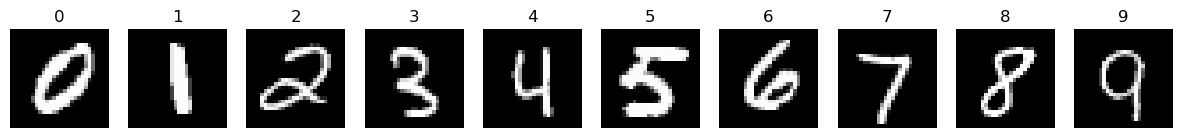

In [23]:
examples_per_digit = {
    0: None,
    1: None,    
    2: None,
    3: None, 
    4: None,
    5: None,
    6: None,
    7: None,
    8: None,
    9: None 
}
count = 0
for images, labels in train_dataloader:
    for i in range(len(labels)):
        digit = labels[i].item()
        if examples_per_digit[digit] is None:
            examples_per_digit[digit] = images[i]
            count +=1
        if count == 10:
            break
    if count == 10:
        break

fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axs[i].imshow(examples_per_digit[i].squeeze(), cmap='gray')
    axs[i].set_title(str(i))
    axs[i].axis('off')
plt.show()
    

### Modeling
Implementing the CNN

#### Using GPU if available

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [76]:
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 15728
Number of validation samples: 3932
Number of test samples: 10000


### CNN Architecture

In [90]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.3)  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x) 
        x = self.fc2(x)
        return x

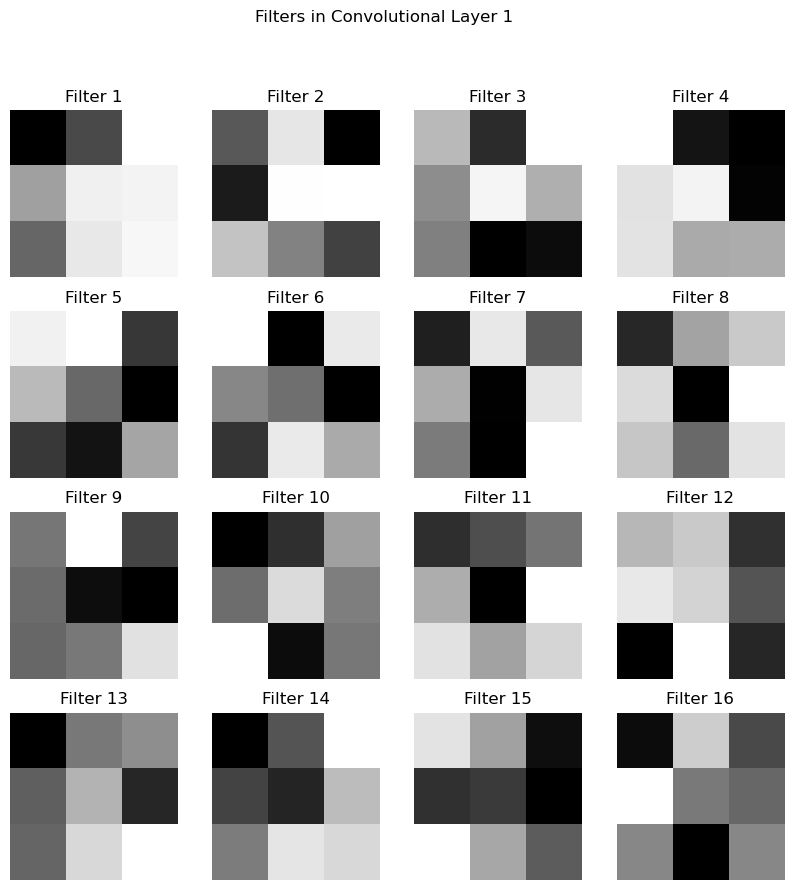

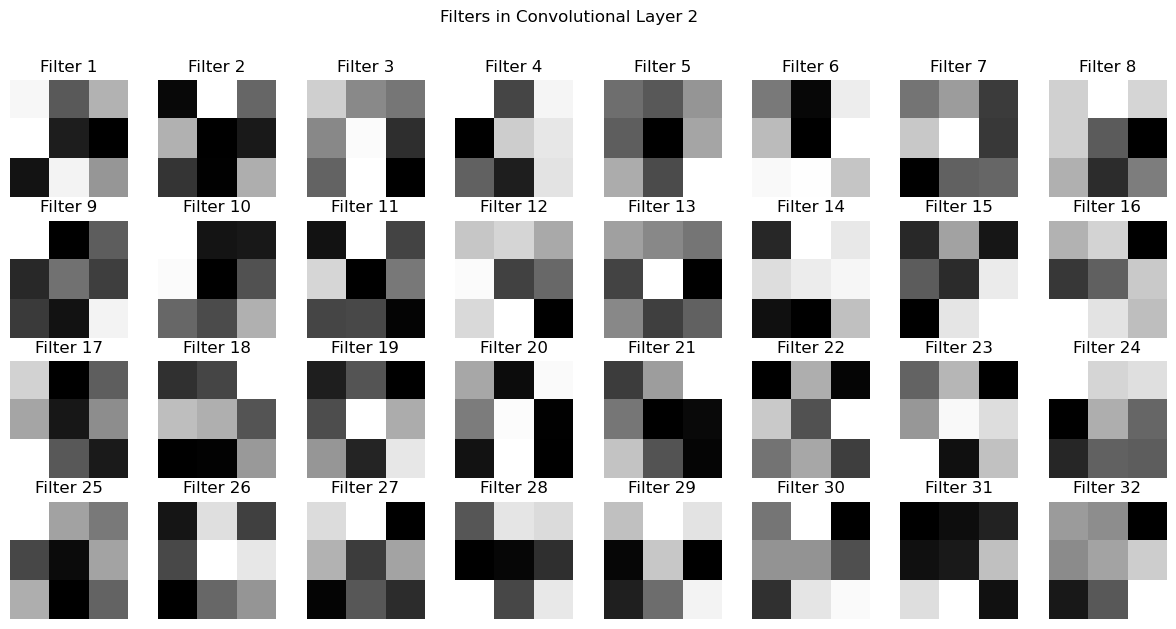

In [91]:
model = CNN()

def visualize_filters(model):
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    filters = model.conv1.weight.data.clone()
    for i in range(16):
        filter = filters[i].numpy()[0, :, :]
        axs[i // 4, i % 4].imshow(filter, cmap='gray')
        axs[i // 4, i % 4].axis('off')
        axs[i // 4, i % 4].set_title(f'Filter {i+1}')
    plt.suptitle('Filters in Convolutional Layer 1')
    plt.show()

    filters = model.conv2.weight.data.clone()
    fig, axs = plt.subplots(4, 8, figsize=(15, 7))
    for i in range(32):
        filter = filters[i].numpy()[0, :, :]
        axs[i // 8, i % 8].imshow(filter, cmap='gray')
        axs[i // 8, i % 8].axis('off')
        axs[i // 8, i % 8].set_title(f'Filter {i+1}')
    plt.suptitle('Filters in Convolutional Layer 2')
    plt.show()

visualize_filters(model)

### Train Model

In [92]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.0001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [93]:
model = CNN()
model.to(device)
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dataloader, val_dataloader, num_epochs=20, learning_rate=0.001)

Epoch [1/20], Train Loss: 0.6246, Train Accuracy: 0.8108, Val Loss: 0.1719, Val Accuracy: 0.9491
Epoch [2/20], Train Loss: 0.1749, Train Accuracy: 0.9474, Val Loss: 0.1254, Val Accuracy: 0.9629
Epoch [3/20], Train Loss: 0.1204, Train Accuracy: 0.9640, Val Loss: 0.0973, Val Accuracy: 0.9708
Epoch [4/20], Train Loss: 0.0934, Train Accuracy: 0.9707, Val Loss: 0.0815, Val Accuracy: 0.9763
Epoch [5/20], Train Loss: 0.0807, Train Accuracy: 0.9750, Val Loss: 0.0766, Val Accuracy: 0.9748
Epoch [6/20], Train Loss: 0.0668, Train Accuracy: 0.9795, Val Loss: 0.0670, Val Accuracy: 0.9789
Epoch [7/20], Train Loss: 0.0567, Train Accuracy: 0.9818, Val Loss: 0.0642, Val Accuracy: 0.9797
Epoch [8/20], Train Loss: 0.0467, Train Accuracy: 0.9849, Val Loss: 0.0650, Val Accuracy: 0.9812
Epoch [9/20], Train Loss: 0.0408, Train Accuracy: 0.9865, Val Loss: 0.0636, Val Accuracy: 0.9791
Epoch [10/20], Train Loss: 0.0340, Train Accuracy: 0.9888, Val Loss: 0.0718, Val Accuracy: 0.9799
Epoch [11/20], Train Loss: 0.

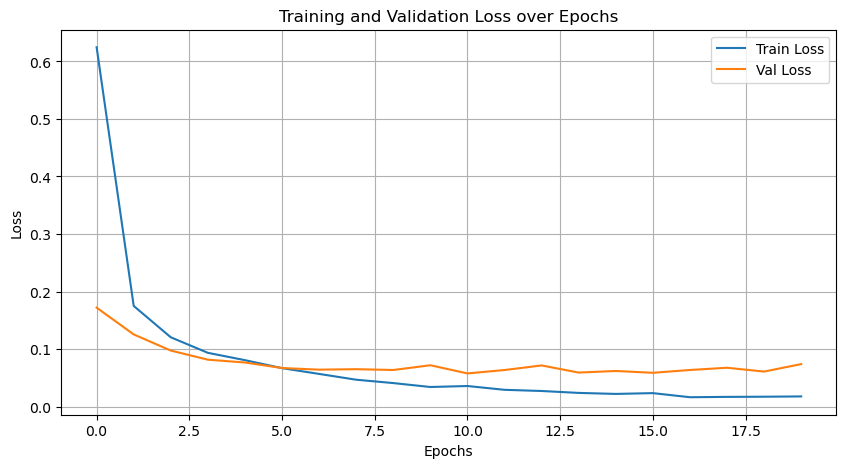

In [94]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Testing Model

In [96]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device) 
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9814


## Conclusions

I ended up testing my model with different hyperparameters: epochs, learning rate, dropout probabilities, optimizers, and criterions. I tested a lr from 0.1 to 0.00001, using the SGD optimizer, and also a wide range of epochs. Even for the worst configurations, my test accuracy was still around 92%. In the end, the current tuning is what I found to be the best solution. Adam optimizer, 20 epochs, dropout probability of 30%, and a lr of 0.001. As you can see from the plot above, the training and validation loss were starting to diverge, so I could have stopped training a little earlier but I don't believe my model started to overfit.

My testing accuracy is 98%, which I am plenty satisfied with.